<hr>
<h1><b>Coursework 2:</b></h1>
<h3><i>Submitted for the partial fulfilment of the DSM150 course</i></h3>
<h3><i>By Hendrik Matthys van Rooyen</i></h3>
<h3><i>230221176</i></h3>

<hr>

# **Music Generation: ADL Piano MIDI Dataset**

---

## Background

### Coursework Evolution

The development of the coursework, from the first to the fourth attempt, saw a series of changes aimed at overcoming specific challenges that were encountered.

Initially, the objective was to successfully read and process a MIDI file, using the `mido` Python library. This stage focused primarily on extracting pitches from MIDI files. However, difficulties arose with `mido` processing certain files, attributed to issues with the selected data structures. An initial attempt was also made to train a basic generative network.

Subsequent revisions led to the adoption of `music21` instead of `mido`. This change was motivated by the need to resolve structural issues and because `music21` facilitated the extraction of a wider range of features in a simpler way. Despite these improvements, only pitch was utilized as a feature, and no attention was given to chords. Efforts were made to implement a system for converting these features into categorical inputs for the network, alongside developing a method for converting data back into MIDI format.

The focus then expanded to include not just pitch, but also the duration of notes. This approach enabled the training of functional networks and the generation of music, though it became apparent that the music lacked overlapping notes due to a failure to treat chords as single units and not considering note offsets.

By the fourth attempt, significant advancements were made by incorporating note pitch, duration, and offsets. This phase aimed to accurately convert songs into data and then back into MIDI without major losses. It also explored accommodating songs that use multiple instruments. However, a challenge emerged with chords, which occupied a large portion of the pitch vocabulary used by the network but were rarely selected in the generated music. Various network models, training durations, and outcomes were experimented with, including the use of floating-point values for durations and offsets, which was ultimately abandoned due to the generated music converging towards a single value.

In the most recent iteration, the handling of chords was refined by eliminating duplicate notes within chords, sorting them alphabetically, and ultimately focusing on the root note of each chord. This adjustment significantly reduced the complexity of the dataset, from over 10,000 combinations to 95. Additionally, durations and offsets were rounded to reduce complexity, and songs were segmented to minimize overlap.

## Implementation

### Read and write MIDI files

#### Reading MIDI Files

**Directory Traversal for MIDI File Collection:** The process begins with the find_midi_files function, which performs a recursive search through the specified directory and its subdirectories, identifying files that end with .mid or .midi extensions. This ensures a thorough collection of all potential MIDI files for analysis, compiling a comprehensive list of paths to these files.

**Musical Data Extraction:** With all MIDI files located, `get_notes_and_durations` comes into play, processing each file individually to extract vital musical information. This step is crucial for understanding the musical composition encoded within each file. It distinguishes between polyphonic structures (which contain distinct instrumental parts) and monophonic structures (which do not), allowing for a nuanced extraction of notes, chords, and rests. Each musical element's duration and offset (the time at which it begins relative to the start of the piece) are also captured. This rich dataset forms the foundation for any subsequent musical analysis or manipulation.

#### Writing MIDI Files

**Reconstruction of MIDI Files:** The `create_midi_from_notes` function undertakes the task of reconstructing a MIDI file from scratch, based on lists of notes, their durations, and offsets. This function exemplifies the synthesis aspect of working with MIDI files, transforming abstract musical concepts back into a structured digital format. By leveraging music21's stream objects, it meticulously assembles a sequence of musical elements, each positioned and timed according to the input lists. This capability enables not just the replication of existing musical pieces but also the creation of entirely new compositions.

#### Application Example

The example code at the end demonstrates how to read specific MIDI files, process them to extract musical elements, and then create a new MIDI file from this data. This demonstrates a full cycle of reading, processing, and writing MIDI data, which can be the basis for more complex operations like musical analysis or automated composition.

In [1]:
from music21 import converter, note, chord, instrument
import numpy as np
import glob
import os

def find_midi_files(directory):
    
    if os.path.isfile(directory) and directory.endswith(('.mid', '.midi')):
        return [directory]
    
    midi_files = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith(('.mid', '.midi')):
                full_path = os.path.join(root, file)
                midi_files.append(full_path)
    return midi_files

def simplify_chord(ch):
    
    new_chord = []
    
    #if(ch.third != None): new_chord.append(ch.third)
    #if(ch.fifth != None): new_chord.append(ch.fifth)
    #if(ch.seventh != None): new_chord.append(ch.seventh)
    
    if(len(new_chord) == 0): new_chord.append(ch.root())
    
    return chord.Chord(new_chord)

def round_time(time):
    if time > 10.0:
        return 10.0
    return round(time * 16) / 16

def get_notes_and_durations(directory):
    """
    Extracts notes, durations, and offsets from MIDI files in a given directory.

    Parameters:
    directory (str): The path to the directory containing MIDI files.

    Returns:
    list: A list of tuples, where each tuple contains three lists: notes, durations, and offsets for a song. Each list in the tuple represents a song in the MIDI files. The notes list contains the pitch of every note (or chord) in the song. The durations list contains the duration of every note (or chord) in quarter lengths. The offsets list contains the start time of every note (or chord) in quarter lengths.
    """
    
    midi_files = find_midi_files(directory)
    all_songs = []

    for index, file in enumerate(midi_files):
        print(f"[{index}] {file}")
        try:
            midi = converter.parse(file)
            parts = instrument.partitionByInstrument(midi)
            if parts:  # file has instrument parts
                notes_to_parse = []
                for part in parts.parts:
                    notes_to_parse.extend([element for element in part.recurse() if isinstance(element, (note.Note, chord.Chord))])
            else:  # file has notes in a flat structure
                notes_to_parse = midi.flat.notesAndRests
        except Exception as e:
            print(f"Error processing {file}: {e}")
            continue
        
        notes_to_parse = sorted(notes_to_parse, key=lambda x: x.offset)
        song_notes, song_durations, song_offsets = [], [], []
        prev_offset = 0
        first_offset = round_time(notes_to_parse[0].offset)

        for element in notes_to_parse:
            if isinstance(element, (note.Note)):
                note_instance = str(element.pitch)
            elif isinstance(element, chord.Chord):
                unique_sorted_notes = sorted(str(n.pitch) for n in simplify_chord(element).notes)
                note_instance = '.'.join(unique_sorted_notes)
            elif isinstance(element, note.Rest):
                note_instance = 'Rest'

            element_offset = element.offset
            offset = round_time(element_offset - prev_offset - first_offset)
            prev_offset = element_offset - first_offset

            song_notes.append(note_instance)
            song_durations.append(round_time(element.duration.quarterLength))
            song_offsets.append(offset)

        all_songs.append((song_notes, song_durations, song_offsets))
    return all_songs

In [2]:
from music21 import stream, note, chord, duration, tempo

def create_midi_from_notes(notes, durations, offsets, output_file_path='output.mid'):
    """
    Create a MIDI file from lists of notes, durations, and offsets.

    Parameters:
    notes (list): A list of note representations. Each representation can be a note (e.g., 'C4'), a chord (e.g., 'C4.E4.G4'), or a rest ('Rest').
    durations (list): A list of durations for each note or chord. Each duration is a float representing the duration in quarter lengths.
    offsets (list): A list of offsets for each note or chord. Each offset is a float representing the time at which the note or chord should start, in quarter lengths.
    output_file_path (str, optional): The path to the output MIDI file. If the directory does not exist, it will be created. Defaults to 'output.mid'.

    Returns:
    None. The function writes the output to a MIDI file at the specified path.
    """
    
    output_directory = os.path.dirname(output_file_path)
    
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)
        
    output_stream = stream.Score()
    
    current_offset = 0
    
    for i, note_repr in enumerate(notes):
        current_offset += offsets[i]
        
        if note_repr == 'Rest':
            new_element = note.Rest()
        elif '.' in note_repr:  # it's a chord
            pitches = note_repr.split('.')
            new_element = chord.Chord(pitches)
        else:  # it's a note
            new_element = note.Note(note_repr)
        
        new_element.duration = duration.Duration(durations[i])
        #print(f"{new_element}: - {new_element.duration.quarterLength} - {offsets[i]}({current_offset})")
        output_stream.insert(current_offset, new_element)
        
    output_stream.write('midi', fp=output_file_path)

In [28]:
import matplotlib.pyplot as plt
from music21 import converter
def plot_piano_roll(midi_path, title='Piano Roll'):
    # Load the MIDI file
    midi = converter.parse(midi_path)
    notes_to_parse = midi.flat.notes

    plt.figure(figsize=(10, 10))

    for note in notes_to_parse:
        if note.isNote:
            start = note.offset
            duration = note.duration.quarterLength
            pitch = str(note.pitch)
            plt.plot([start, start + duration], [pitch, pitch], color="blue", linewidth=5)
        elif note.isChord:
            start = note.offset
            duration = note.duration.quarterLength
            for p in note.pitches:
                pitch = str(p)
                plt.plot([start, start + duration], [pitch, pitch], color="blue", linewidth=5)

    plt.title(title)
    plt.xlabel('Time (in quarter length)')
    plt.ylabel('MIDI Note Number')
    plt.grid(True)
    plt.show()

In [4]:
#adl-piano-midi\\Rock\\Soft Rock\\Phil Collins
#adl-piano-midi\\Classical\\Classical\\Frederic Chopin
#adl-piano-midi\\Rock\\Glam Rock\\Elton John\\
#adl-piano-midi\Rock\Album Rock
#'\\Blues\\Ragtime\\Sue Keller'
#'\\World\\Swedish Pop\\Abba'
folder_path = '\\Rock\\Soft Rock\\Lionel Richie\\Say You Say Me.mid'
songs = get_notes_and_durations('adl-piano-midi'+folder_path)

[0] adl-piano-midi\Rock\Soft Rock\Lionel Richie\Say You Say Me.mid


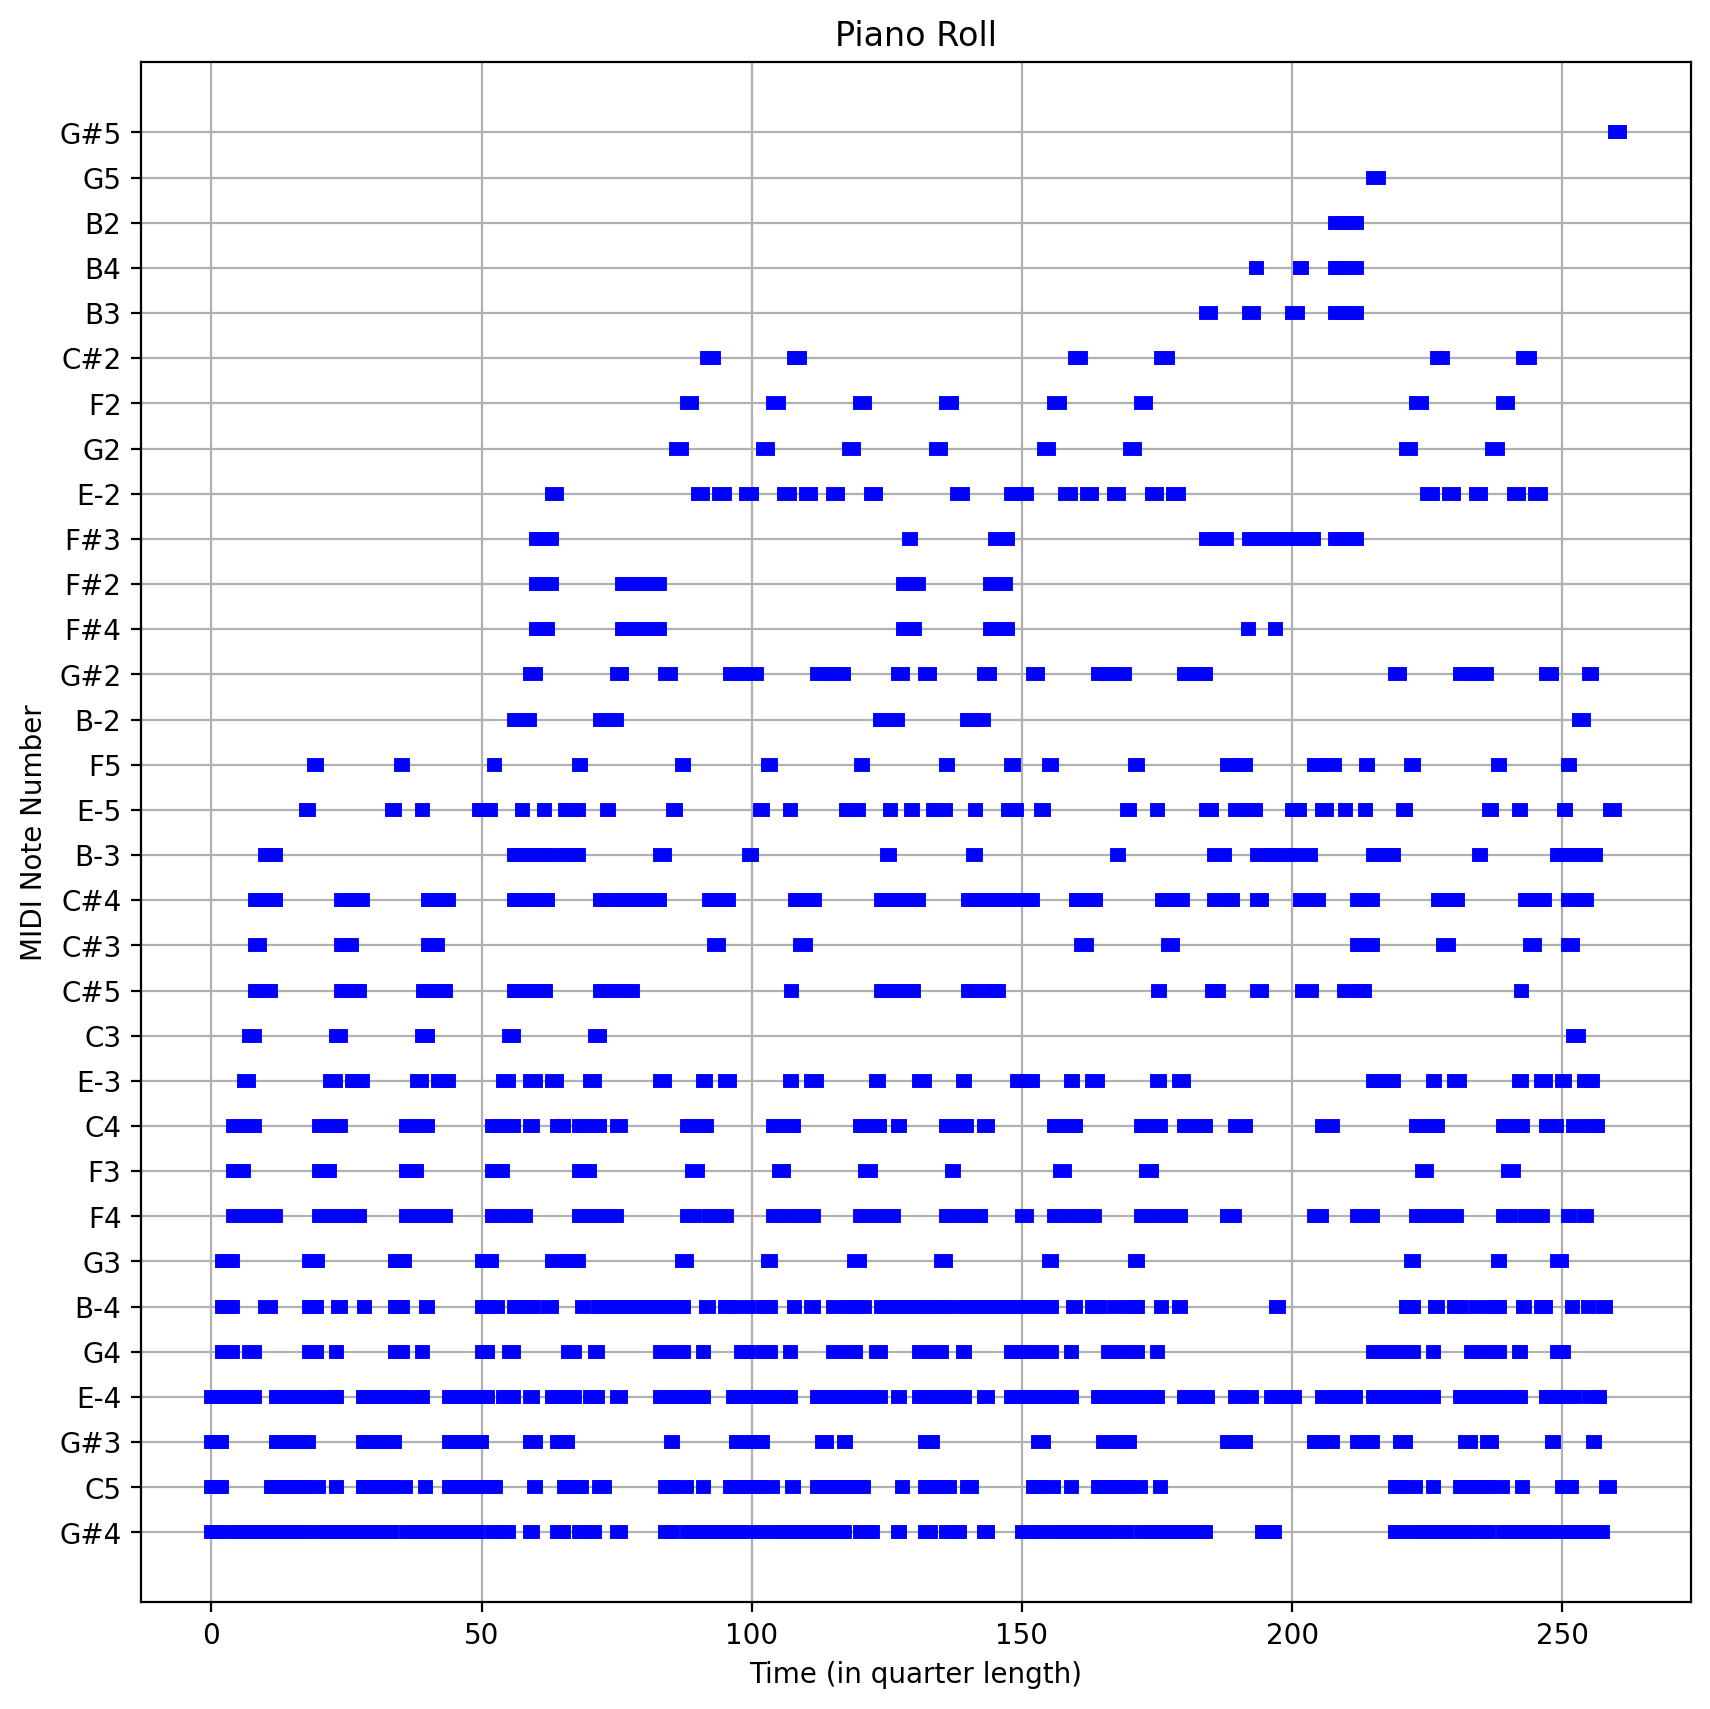

In [29]:
plot_piano_roll('adl-piano-midi\\Rock\\Soft Rock\\Lionel Richie\\Say You Say Me.mid')

In [6]:
#test_index = 5
#create_midi_from_notes(songs[test_index][0], songs[test_index][1], songs[test_index][2], './generation test files/soft rock 11.mid')

<p style="page-break-after:always;"></p>

### Pre-process Data

The main goal of this section is to organize and transform the musical data into a structured form that neural networks can learn from. This involves converting musical elements into numerical representations and structuring these into sequences that serve as inputs for the model.

#### Steps Involved

**1. Initialization and Data Preparation:**

Empty lists (`all_notes`, `all_durations`, `all_offsets`) are initialized to store the extracted musical elements from multiple MIDI files.

A transition_marker is defined to signify the end of a song within the dataset, ensuring that the model recognizes song boundaries during training.

**2. Data Consolidation:**

Iterating through a collection of songs, the code appends notes, durations, and offsets from each song into the respective lists. This step includes adding the transition_marker between songs to maintain the distinction between consecutive songs in the dataset.

**3. Vocabulary Construction:**

By removing the transition markers and calculating the unique elements in each category (notes, durations, offsets), the code establishes the vocabulary size for each aspect of the musical data.

**4. Mapping Creation:**

Dictionaries (`note_to_int`, `duration_to_int`, `offset_to_int`) are created to map each unique musical element to an integer, facilitating the numerical representation necessary for machine learning models.

**5. Sequence Preparation:**

The code constructs sequences of a fixed length (`sequence_length`) from the combined lists, excluding sequences containing the transition marker to prevent the model from learning to transition between unrelated songs.

**6. Data Formatting for Neural Network Training:**

Input sequences are reshaped and normalized based on the vocabulary size for each element type. This normalization is critical for learning, as it helps in maintaining a consistent scale across the dataset.

Outputs are one-hot encoded, turning them into binary class matrices, essential for classification tasks within neural networks.

In [7]:
from keras.utils import to_categorical
import numpy as np

sequence_length = 50

all_notes = []
all_durations = []
all_offsets = []

# Define a special marker for transitions between songs
transition_marker = ('<end_song>', -1, -1)

# Iterate through each tuple in the list and add transition markers
for tuple_ in songs:
    all_notes.extend(tuple_[0] + [transition_marker[0]])
    all_durations.extend(tuple_[1] + [transition_marker[1]])
    all_offsets.extend(tuple_[2] + [transition_marker[2]])

# Remove the last added marker as it is not needed after the last song
all_notes.pop()
all_durations.pop()
all_offsets.pop()

n_vocab = len(set(all_notes))
d_vocab = len(set(all_durations))
o_vocab = len(set(all_offsets))

if(len(songs) > 1):

    n_vocab = n_vocab - 1
    d_vocab = n_vocab - 1
    o_vocab = n_vocab - 1
print((n_vocab, d_vocab, o_vocab))

pitchnames = sorted(set(all_notes) - {transition_marker[0]})
durationnames = sorted(set(all_durations) - {transition_marker[1]})
offsetnames = sorted(set(all_offsets) - {transition_marker[2]})

note_to_int = dict((note, number) for number, note in enumerate(pitchnames))
duration_to_int = dict((duration, number) for number, duration in enumerate(durationnames))
offset_to_int = dict((offset, number) for number, offset in enumerate(offsetnames))

network_input_notes = []
network_input_durations = []
network_input_offsets = []

network_output_notes = []
network_output_durations = []
network_output_offsets = []

for i in range(len(all_notes) - sequence_length):
    if transition_marker[0] not in all_notes[i:i + sequence_length + 1]:
        sequence_in_notes = all_notes[i:i + sequence_length]
        sequence_out_note = all_notes[i + sequence_length]

        sequence_in_durations = all_durations[i:i + sequence_length]
        sequence_out_duration = all_durations[i + sequence_length]

        sequence_in_offsets = all_offsets[i:i + sequence_length]
        sequence_out_offset = all_offsets[i + sequence_length]

        network_input_notes.append([note_to_int[note] / n_vocab for note in sequence_in_notes])
        network_input_durations.append([duration_to_int[duration] / d_vocab for duration in sequence_in_durations])
        network_input_offsets.append([offset_to_int[offset] / o_vocab for offset in sequence_in_offsets])

        network_output_notes.append(note_to_int[sequence_out_note])
        network_output_durations.append(duration_to_int[sequence_out_duration])
        network_output_offsets.append(offset_to_int[sequence_out_offset])

network_input_notes = np.reshape(network_input_notes, (len(network_input_notes), sequence_length, 1))
network_input_durations = np.reshape(network_input_durations, (len(network_input_durations), sequence_length, 1))
network_input_offsets = np.reshape(network_input_offsets, (len(network_input_offsets), sequence_length, 1))

network_output_notes = to_categorical(network_output_notes, num_classes=n_vocab)
network_output_durations = to_categorical(network_output_durations, num_classes=d_vocab)
network_output_offsets = to_categorical(network_output_offsets, num_classes=o_vocab)

(31, 7, 12)


In [8]:
network_input_notes.shape

(777, 50, 1)

This preprocessing step is fundamental to the machine learning pipeline presented in the notebook. It bridges the gap between the raw musical data extracted from MIDI files and the data's actual application in training neural network models. By converting musical elements into a structured and numerical format, it enables the subsequent steps of model design, training, and eventually music generation based on learned patterns. This approach exemplifies how data from creative domains like music can be made amenable to computational techniques, paving the way for innovative applications like automated composition and interactive music systems.

### Design Network

This model utilizes separate LSTM (Long Short-Term Memory) layers for each type of musical element (notes, durations, offsets), integrating dropout layers to reduce overfitting. The outputs from these LSTM layers are then fed into dense layers to predict the next note, duration, and offset, respectively. This design aims to learn and generate music by understanding the patterns in note sequences, note durations, and their timings independently before making predictions.

In [9]:
model_num = 4

In [10]:
from keras.layers import Input, LSTM, Dropout, Dense
from keras.models import Model

if(model_num == 1):

    # Input layer
    input_notes = Input(shape=(network_input_notes.shape[1], network_input_notes.shape[2]), name='input_notes')
    input_durations = Input(shape=(network_input_durations.shape[1], network_input_durations.shape[2]), name='input_durations')
    input_offsets = Input(shape=(network_input_offsets.shape[1], network_input_offsets.shape[2]), name='input_offsets')

    # Shared LSTM layers for notes
    lstm_notes1 = LSTM(256, return_sequences=True)(input_notes)
    dropout_notes1 = Dropout(0.3)(lstm_notes1)
    lstm_notes2 = LSTM(256)(dropout_notes1)
    dropout_notes2 = Dropout(0.3)(lstm_notes2)

    # Shared LSTM layers for durations
    lstm_durations1 = LSTM(256, return_sequences=True)(input_durations)
    dropout_durations1 = Dropout(0.3)(lstm_durations1)
    lstm_durations2 = LSTM(256)(dropout_durations1)
    dropout_durations2 = Dropout(0.3)(lstm_durations2)

    # Shared LSTM layers for offsets
    lstm_offsets1 = LSTM(256, return_sequences=True)(input_offsets)
    dropout_offsets1 = Dropout(0.3)(lstm_offsets1)
    lstm_offsets2 = LSTM(256)(dropout_offsets1)
    dropout_offsets2 = Dropout(0.3)(lstm_offsets2)

    # Separate output layers for notes and durations
    notes_output = Dense(n_vocab, activation='softmax', name='notes_output')(dropout_notes2)
    durations_output = Dense(d_vocab, activation='softmax', name='durations_output')(dropout_durations2)
    offsets_output = Dense(o_vocab, activation='softmax', name='offsets_output')(dropout_offsets2)

    model = Model(inputs=[input_notes, input_durations, input_offsets], outputs=[notes_output, durations_output, offsets_output])

    model.compile(loss={'notes_output': 'categorical_crossentropy', 'durations_output': 'categorical_crossentropy', 'offsets_output': 'categorical_crossentropy'}, optimizer='rmsprop')

    model.summary()

The second model introduces bidirectional LSTMs and a concatenation layer, enhancing the model's ability to capture patterns in both forward and backward directions of the sequences. This design is more complex and aims to improve the network's understanding of the musical data by integrating information from notes, durations, and offsets simultaneously before making predictions. This could potentially lead to better generation of musical sequences that are coherent and musically pleasing.

In [11]:
from keras.layers import Input, LSTM, Dropout, Dense, Concatenate, Bidirectional
from keras.models import Model

if(model_num == 2):
    
    # Input layer
    input_notes = Input(shape=(network_input_notes.shape[1], network_input_notes.shape[2]), name='input_notes')
    input_durations = Input(shape=(network_input_durations.shape[1], network_input_durations.shape[2]), name='input_durations')
    input_offsets = Input(shape=(network_input_offsets.shape[1], network_input_offsets.shape[2]), name='input_offsets')

    # Shared LSTM layers for notes
    lstm_notes1 = Bidirectional(LSTM(256, return_sequences=True))(input_notes)
    dropout_notes1 = Dropout(0.3)(lstm_notes1)

    # Shared LSTM layers for durations
    lstm_durations1 = LSTM(256, return_sequences=True)(input_durations)
    dropout_durations1 = Dropout(0.3)(lstm_durations1)

    # Shared LSTM layers for offsets
    lstm_offsets1 = LSTM(256, return_sequences=True)(input_offsets)
    dropout_offsets1 = Dropout(0.3)(lstm_offsets1)

    # Concatenation layer - Combining all features
    concat_layer = Concatenate()([dropout_notes1, dropout_durations1, dropout_offsets1])

    # Final LSTM layer to interpret the combined features
    combined_features = LSTM(256)(concat_layer)
    combined_dropout = Dropout(0.3)(combined_features)

    # Separate output layers for notes and durations
    notes_output = Dense(n_vocab, activation='softmax', name='notes_output')(combined_dropout)
    durations_output = Dense(d_vocab, activation='softmax', name='durations_output')(combined_dropout)
    offsets_output = Dense(o_vocab, activation='softmax', name='offsets_output')(combined_dropout)

    model = Model(inputs=[input_notes, input_durations, input_offsets], outputs=[notes_output, durations_output, offsets_output])

    model.compile(loss={'notes_output': 'categorical_crossentropy', 'durations_output': 'categorical_crossentropy', 'offsets_output': 'categorical_crossentropy'}, optimizer='rmsprop')

    model.summary()

The third and most advanced model incorporates embedding layers for notes, durations, and offsets, followed by bidirectional LSTMs and an attention mechanism. The embeddings provide a dense representation of the musical elements, while the attention mechanism allows the model to focus on specific parts of the input sequences when making predictions. This model is designed to capture more nuanced patterns and relationships within the musical data, potentially leading to the generation of complex and varied musical compositions.

In [12]:
from keras.layers import Input, LSTM, Dropout, Dense, Concatenate, Embedding, Bidirectional, Attention
from keras.models import Model

if(model_num == 3):
      max_sequence_length = 50
      note_embedding_size = 100
      duration_embedding_size = 50
      offset_embedding_size = 50

      # Input layers
      input_notes = Input(shape=(max_sequence_length,), name='input_notes')
      input_durations = Input(shape=(max_sequence_length,), name='input_durations')
      input_offsets = Input(shape=(max_sequence_length,), name='input_offsets')

      # Embedding layers
      note_embedding = Embedding(input_dim=n_vocab, output_dim=n_vocab)(input_notes)
      duration_embedding = Embedding(input_dim=d_vocab, output_dim=n_vocab)(input_durations)
      offset_embedding = Embedding(input_dim=o_vocab, output_dim=n_vocab)(input_offsets)

      # Shared LSTM layers for notes, durations, and offsets
      # Using Bidirectional LSTMs to capture patterns in both directions
      lstm_notes = Bidirectional(LSTM(256, return_sequences=True))(note_embedding)
      dropout_notes = Dropout(0.3)(lstm_notes)

      lstm_durations = Bidirectional(LSTM(256, return_sequences=True))(duration_embedding)
      dropout_durations = Dropout(0.3)(lstm_durations)

      lstm_offsets = Bidirectional(LSTM(256, return_sequences=True))(offset_embedding)
      dropout_offsets = Dropout(0.3)(lstm_offsets)

      # Attention Mechanism
      attention_notes = Attention()([dropout_notes, dropout_notes])
      attention_durations = Attention()([dropout_durations, dropout_durations])
      attention_offsets = Attention()([dropout_offsets, dropout_offsets])

      # Concatenation layer - Combining all features
      concat_layer = Concatenate()([attention_notes, attention_durations, attention_offsets])

      # Final LSTM layer to interpret the combined features
      combined_features = LSTM(256)(concat_layer)
      combined_dropout = Dropout(0.3)(combined_features)

      # Separate output layers for notes, durations, and offsets
      notes_output = Dense(n_vocab, activation='softmax', name='notes_output')(combined_dropout)
      durations_output = Dense(d_vocab, activation='softmax', name='durations_output')(combined_dropout)
      offsets_output = Dense(o_vocab, activation='softmax', name='offsets_output')(combined_dropout)

      model = Model(inputs=[input_notes, input_durations, input_offsets], outputs=[notes_output, durations_output, offsets_output])

      model.compile(loss={'notes_output': 'categorical_crossentropy',
                        'durations_output': 'categorical_crossentropy',
                        'offsets_output': 'categorical_crossentropy'},
                  optimizer='adam')

      model.summary()

For the fourth, a simplified approach is explored, receiving all three inputs and concatenating them immediately, this is done in order to explore the capability of simpler models.

In exploring this model it also became clear that the networks overfit nearly instantly

In [13]:
from keras.layers import Input, LSTM, Dropout, Dense, Concatenate, Bidirectional
from keras.models import Model

from keras.optimizers import Adam

if(model_num == 4):

    # Input layer
    input_notes = Input(shape=(network_input_notes.shape[1], network_input_notes.shape[2]), name='input_notes')
    input_durations = Input(shape=(network_input_durations.shape[1], network_input_durations.shape[2]), name='input_durations')
    input_offsets = Input(shape=(network_input_offsets.shape[1], network_input_offsets.shape[2]), name='input_offsets')

    # Concatenation layer - Combining all features
    concat_layer = Concatenate()([input_notes, input_durations, input_offsets])

    # LSTM layer to interpret the combined features
    combined_features1 = Bidirectional(LSTM(512, return_sequences=True))(concat_layer)
    dropout_offsets1 = Dropout(0.3)(combined_features1)
    
    # Final LSTM layer to interpret the combined features
    combined_features2 = Bidirectional(LSTM(512))(dropout_offsets1)
    dropout_offsets2 = Dropout(0.3)(combined_features2)
    
    # Separate output layers for notes and durations
    notes_output = Dense(n_vocab, activation='softmax', name='notes_output')(dropout_offsets2)
    durations_output = Dense(d_vocab, activation='softmax', name='durations_output')(dropout_offsets2)
    offsets_output = Dense(o_vocab, activation='softmax', name='offsets_output')(dropout_offsets2)

    model = Model(inputs=[input_notes, input_durations, input_offsets], outputs=[notes_output, durations_output, offsets_output])

    optimizer = Adam(learning_rate=0.005)

    model.compile(
        loss={'notes_output': 'categorical_crossentropy', 'durations_output': 'categorical_crossentropy', 'offsets_output': 'categorical_crossentropy'},
        loss_weights={'notes_output': 1.0, 'durations_output': 1.0, 'offsets_output': 1.0},
        optimizer=optimizer)

    model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_notes         │ (None, 50, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_durations     │ (None, 50, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_offsets       │ (None, 50, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 50, 3)     │          0 │ input_notes[0][0… │
│ (Concatenate)       │                   │            │ input_durations[… │
│                     │                   │            │ input_offsets[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 50, 1024)  │  2,113,536 │ concatenate[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 50, 1024)  │          0 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 1024)      │  6,295,552 │ dropout[0][0]     │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 1024)      │          0 │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ notes_output        │ (None, 31)        │     31,775 │ dropout_1[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ durations_output    │ (None, 7)         │      7,175 │ dropout_1[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ offsets_output      │ (None, 12)        │     12,300 │ dropout_1[0][0]   │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 8,460,338 (32.27 MB)

 Trainable params: 8,460,338 (32.27 MB)

 Non-trainable params: 0 (0.00 B)

The design of these neural networks is a crucial step that follows data preprocessing. Once the musical elements have been encoded into numerical sequences, these networks are tasked with learning the underlying patterns in music compositions, such as which notes tend to follow others, how long each note is held, and the timing between notes.

After designing and compiling these models, the next steps involve training them on the preprocessed data, evaluating their performance, and then using the trained models to generate new music. The complexity of the network design directly impacts the learning capacity of the models. More complex models, like those with bidirectional LSTMs and attention mechanisms, may capture more detailed and nuanced patterns in the data but also require more computational resources and data to train effectively.

### Train Network

Training involves feeding the neural network models with the sequences of notes, durations, and offsets prepared during the data preprocessing step. Each model then attempts to predict the next note, its duration, and offset based on a given sequence. The training process adjusts the model's weights to minimize the discrepancy between its predictions and the actual next elements in the sequences. This iterative process is facilitated through epochs, where an epoch represents one complete pass through the entire training dataset.

The success of the training process directly impacts the model's ability to generate new, coherent, and musically pleasing compositions. The models' performances during training, observed through changes in loss, offer insight into their learning progress and readiness for generating music.

**Targets Definition:**

A dictionary named targets is defined, mapping each output component of the model—notes, durations, and offsets—to its corresponding dataset prepared earlier. This mapping is essential for supervised learning, where the model learns to predict multiple aspects of music simultaneously.

**Callbacks Configuration:**

Two key callbacks are configured for the training process:
- ModelCheckpoint saves the model at different stages during training, allowing the retention of the model that performs best on the validation set based on the minimum validation loss (val_loss). This mechanism ensures that the most effective version of the model is preserved, facilitating further refinement or deployment.
- EarlyStopping monitors the validation loss and stops the training process if the loss does not improve for a specified number of epochs (patience). This callback prevents overfitting by halting the training when the model ceases to learn from the data.

**Model Training:**

The model.fit method trains the neural network model on the prepared data. It specifies the input data (network_input_notes, network_input_durations, network_input_offsets) and the targets (notes, durations, offsets), batch size, number of epochs, callbacks, and the fraction of data to be used as validation data.

Training the model with these parameters allows the network to learn from the data, adjusting its weights to minimize the loss function. The validation split helps in monitoring the model's performance on unseen data, providing insights into its generalization ability.

    A note on the training times, it seems that, understandably, the training times can vary drastically.

    Since moving over to the split inputs, the training times has been much shorter. The sequence length also seem to have a large impact on training time, however a longer sequence do tend to see a steeper drop in the loss of the training, presumably requiering less epochs to reach the same point in training.



In [14]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
targets = {
    'notes_output': network_output_notes,
    'durations_output': network_output_durations,
    'offsets_output' : network_output_offsets
}

callbacks = [
    ModelCheckpoint(
        filepath='./training_checkpoints/ckpt_{epoch}.keras',
        save_best_only = True,
        monitor='val_loss',
        mode='min'),
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        verbose=1,
        restore_best_weights=True),
]

# Training the model
history = model.fit(
    x=[network_input_notes, network_input_durations, network_input_offsets],
    y=targets,
    batch_size=64,
    epochs=15,
    callbacks = callbacks,
    validation_split = 0.25
)

Epoch 1/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - loss: 7.7781 - val_loss: 8.1025
Epoch 2/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 708ms/step - loss: 6.3614 - val_loss: 8.1324
Epoch 3/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 765ms/step - loss: 6.0541 - val_loss: 7.8065
Epoch 4/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 741ms/step - loss: 5.8421 - val_loss: 7.7523
Epoch 5/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 704ms/step - loss: 5.8772 - val_loss: 7.7877
Epoch 6/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 698ms/step - loss: 5.7561 - val_loss: 7.7641
Epoch 7/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 761ms/step - loss: 5.7648 - val_loss: 7.6322
Epoch 8/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 704ms/step - loss: 5.7733 - val_loss: 7.7394
Epoch 9/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 690ms/step - loss: 5.7974 - val_loss: 7.8742
Epoch 10/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 690ms/step - loss: 5.6704 - val_loss: 7.6545
Epoch 11/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 716ms/step - loss: 5.7286 - val_loss: 7.8352
Epoch 12/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 704ms/step -

<p style="page-break-after:always;"></p>

### Generate Music

The section represents the culmination of the notebook's workflow, transitioning from the theoretical and preparatory stages of designing neural networks and training them on musical data to the practical application of these trained models for music generation. This phase is where the models, now trained to understand and predict musical patterns, are tasked with creating new music sequences based on the knowledge they have acquired.

#### Key Steps in Music Generation

**1. Seed Selection:**

The generation process begins by selecting a starting sequence (or seed) from the input data. This sequence is used to kickstart the generation process, providing the initial context from which the model begins making predictions.

**2. Iterative Prediction:**

Using the seed, the model predicts the next note, its duration, and its offset. These predictions are based on the patterns the model has learned during training. The predicted elements are then appended to the sequence, and the process is repeated, each time using the most recent sequence of notes to predict the next elements. This iterative process allows for the generation of music that is coherent and follows the structural patterns observed in the training data.

**3. Temperature Parameter:**

A temperature parameter is utilized to introduce variability in the predictions. Lower temperatures lead to more predictable and less varied outputs, while higher temperatures increase diversity and the potential for unexpected results. This parameter helps control the balance between coherence and creativity in the generated music.

**4. Music Reconstruction:**

The sequences of predicted notes, durations, and offsets are translated back into a musical format, typically using the same library or toolset (music21) that was used for initial data processing. This involves converting the numerical representations back into musical notes and rhythms and assembling them into a coherent composition.

**5. MIDI Conversion:**

The reconstructed musical composition is then converted into a MIDI file, a standard digital format that represents music, allowing for playback, editing, and further manipulation using various music software.

In [15]:
import numpy as np
from tensorflow.keras.models import load_model
from music21 import instrument, note, stream, chord

def sample_with_temperature(predictions, temperature=1.0):
    """
    Adjust the randomness of the model's predictions by applying temperature scaling.

    Parameters:
    predictions (numpy.ndarray): The array of predictions from the model.
    temperature (float, optional): The parameter for scaling the prediction values. Higher values make the predictions more random, lower values make the predictions more confident. Defaults to 1.0.

    Returns:
    int: The index of the chosen prediction after applying temperature scaling and sampling from the probability distribution.
    """
    
    predictions = np.asarray(predictions).astype('float64')
    predictions = np.log(predictions + 1e-7) / temperature  # Prevent log(0) by adding a small constant
    exp_preds = np.exp(predictions)
    predictions = exp_preds / np.sum(exp_preds)
    probabilities = np.random.multinomial(1, predictions, 1)
    return np.argmax(probabilities)

def generate_notes_and_durations(model, network_input, pitchnames, durationnames, offsetnames, vocab, notes = 100, temperature=1.0):
    """
    Generate notes and their durations from the neural network based on a sequence of notes.

    Parameters:
    model (keras.Model): The trained model to generate the notes and durations.
    network_input (tuple): A tuple containing the input sequences for notes, durations, and offsets.
    pitchnames (list): A list of all unique pitch names.
    durationnames (list): A list of all unique duration names.
    offsetnames (list): A list of all unique offset names.
    vocab (tuple): A tuple containing the total number of unique notes, durations, and offsets.
    notes (int, optional): The number of notes to be generated. Defaults to 100.
    temperature (float, optional): The temperature for the softmax function. Defaults to 1.0.

    Returns:
    tuple: A tuple containing three lists: the generated notes, durations, and offsets.
    """
    
    (network_input_notes, network_input_durations, network_input_offsets) = network_input
    (n_vocab, d_vocab, o_vocab) = vocab
    
    start = np.random.randint(0, len(network_input_notes)-1)
    
    int_to_note = dict((number, note) for number, note in enumerate(pitchnames))
    int_to_duration = dict((number, duration) for number, duration in enumerate(durationnames))
    int_to_offset = dict((number, offset) for number, offset in enumerate(offsetnames))

    prediction_input_notes = np.reshape(network_input_notes[start], (1, len(network_input_notes[start]), 1))
    prediction_input_durations = np.reshape(network_input_durations[start], (1, len(network_input_durations[start]), 1))
    prediction_input_offsets = np.reshape(network_input_offsets[start], (1, len(network_input_offsets[start]), 1))
    
    pattern = [prediction_input_notes, prediction_input_durations, prediction_input_offsets]

    prediction_output = []

    # Generate 100 notes and their durations
    for note_index in range(notes):
                
        prediction = model.predict(pattern, verbose=0)
        note_prediction, duration_prediction, offset_prediction = prediction
        
        # Predict the note
        note_index = sample_with_temperature(note_prediction[0], temperature=temperature)
        predicted_note = int_to_note[note_index]

        # Predict the duration
        duration_index = sample_with_temperature(duration_prediction[0], temperature=temperature)
        predicted_duration = int_to_duration[duration_index]
        
        # Predict the duration
        offset_index = sample_with_temperature(offset_prediction[0], temperature=temperature)
        predicted_offset = int_to_offset[offset_index]
        
        prediction_output = (prediction_output[0] + [predicted_note], prediction_output[1] + [predicted_duration], prediction_output[2] + [predicted_offset]) if prediction_output else ([predicted_note], [predicted_duration], [predicted_offset])

        prediction_input_notes = np.append(prediction_input_notes, [note_index / float(n_vocab)])[1:]
        prediction_input_notes = np.reshape(network_input_notes[start], (1, len(network_input_notes[start]), 1))
        
        prediction_input_durations = np.append(prediction_input_durations, [note_index / float(d_vocab)])[1:]
        prediction_input_durations = np.reshape(network_input_durations[start], (1, len(network_input_durations[start]), 1))
        
        prediction_input_offsets = np.append(prediction_input_durations, [note_index / float(o_vocab)])[1:]
        prediction_input_offsets = np.reshape(network_input_offsets[start], (1, len(network_input_offsets[start]), 1))
        
        pattern = [prediction_input_notes, prediction_input_durations, prediction_input_offsets]

    return prediction_output

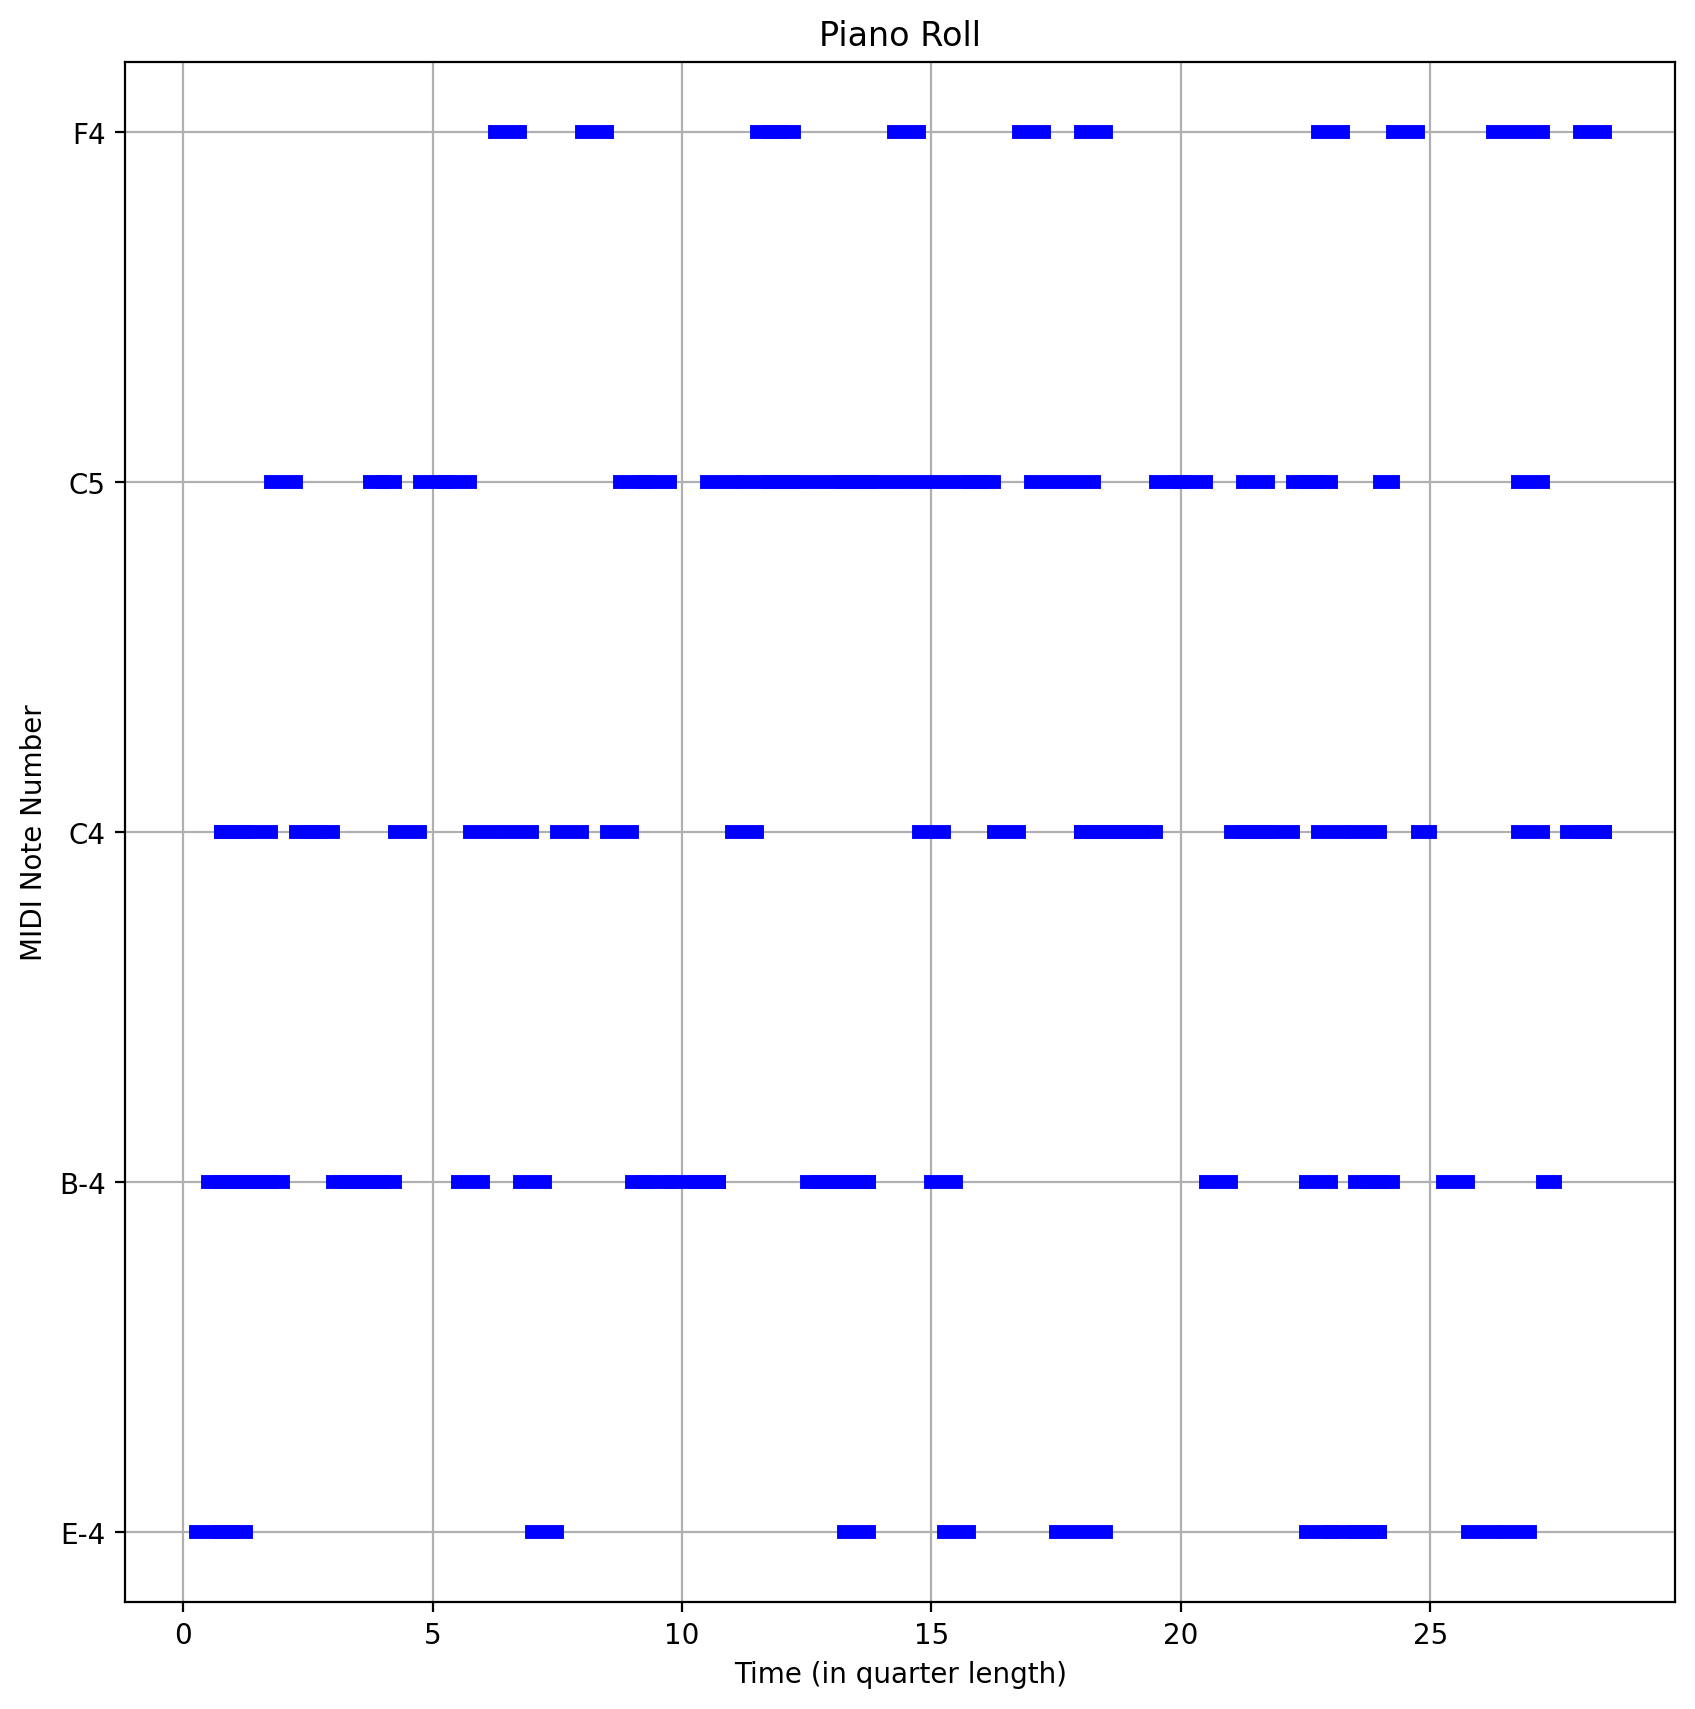

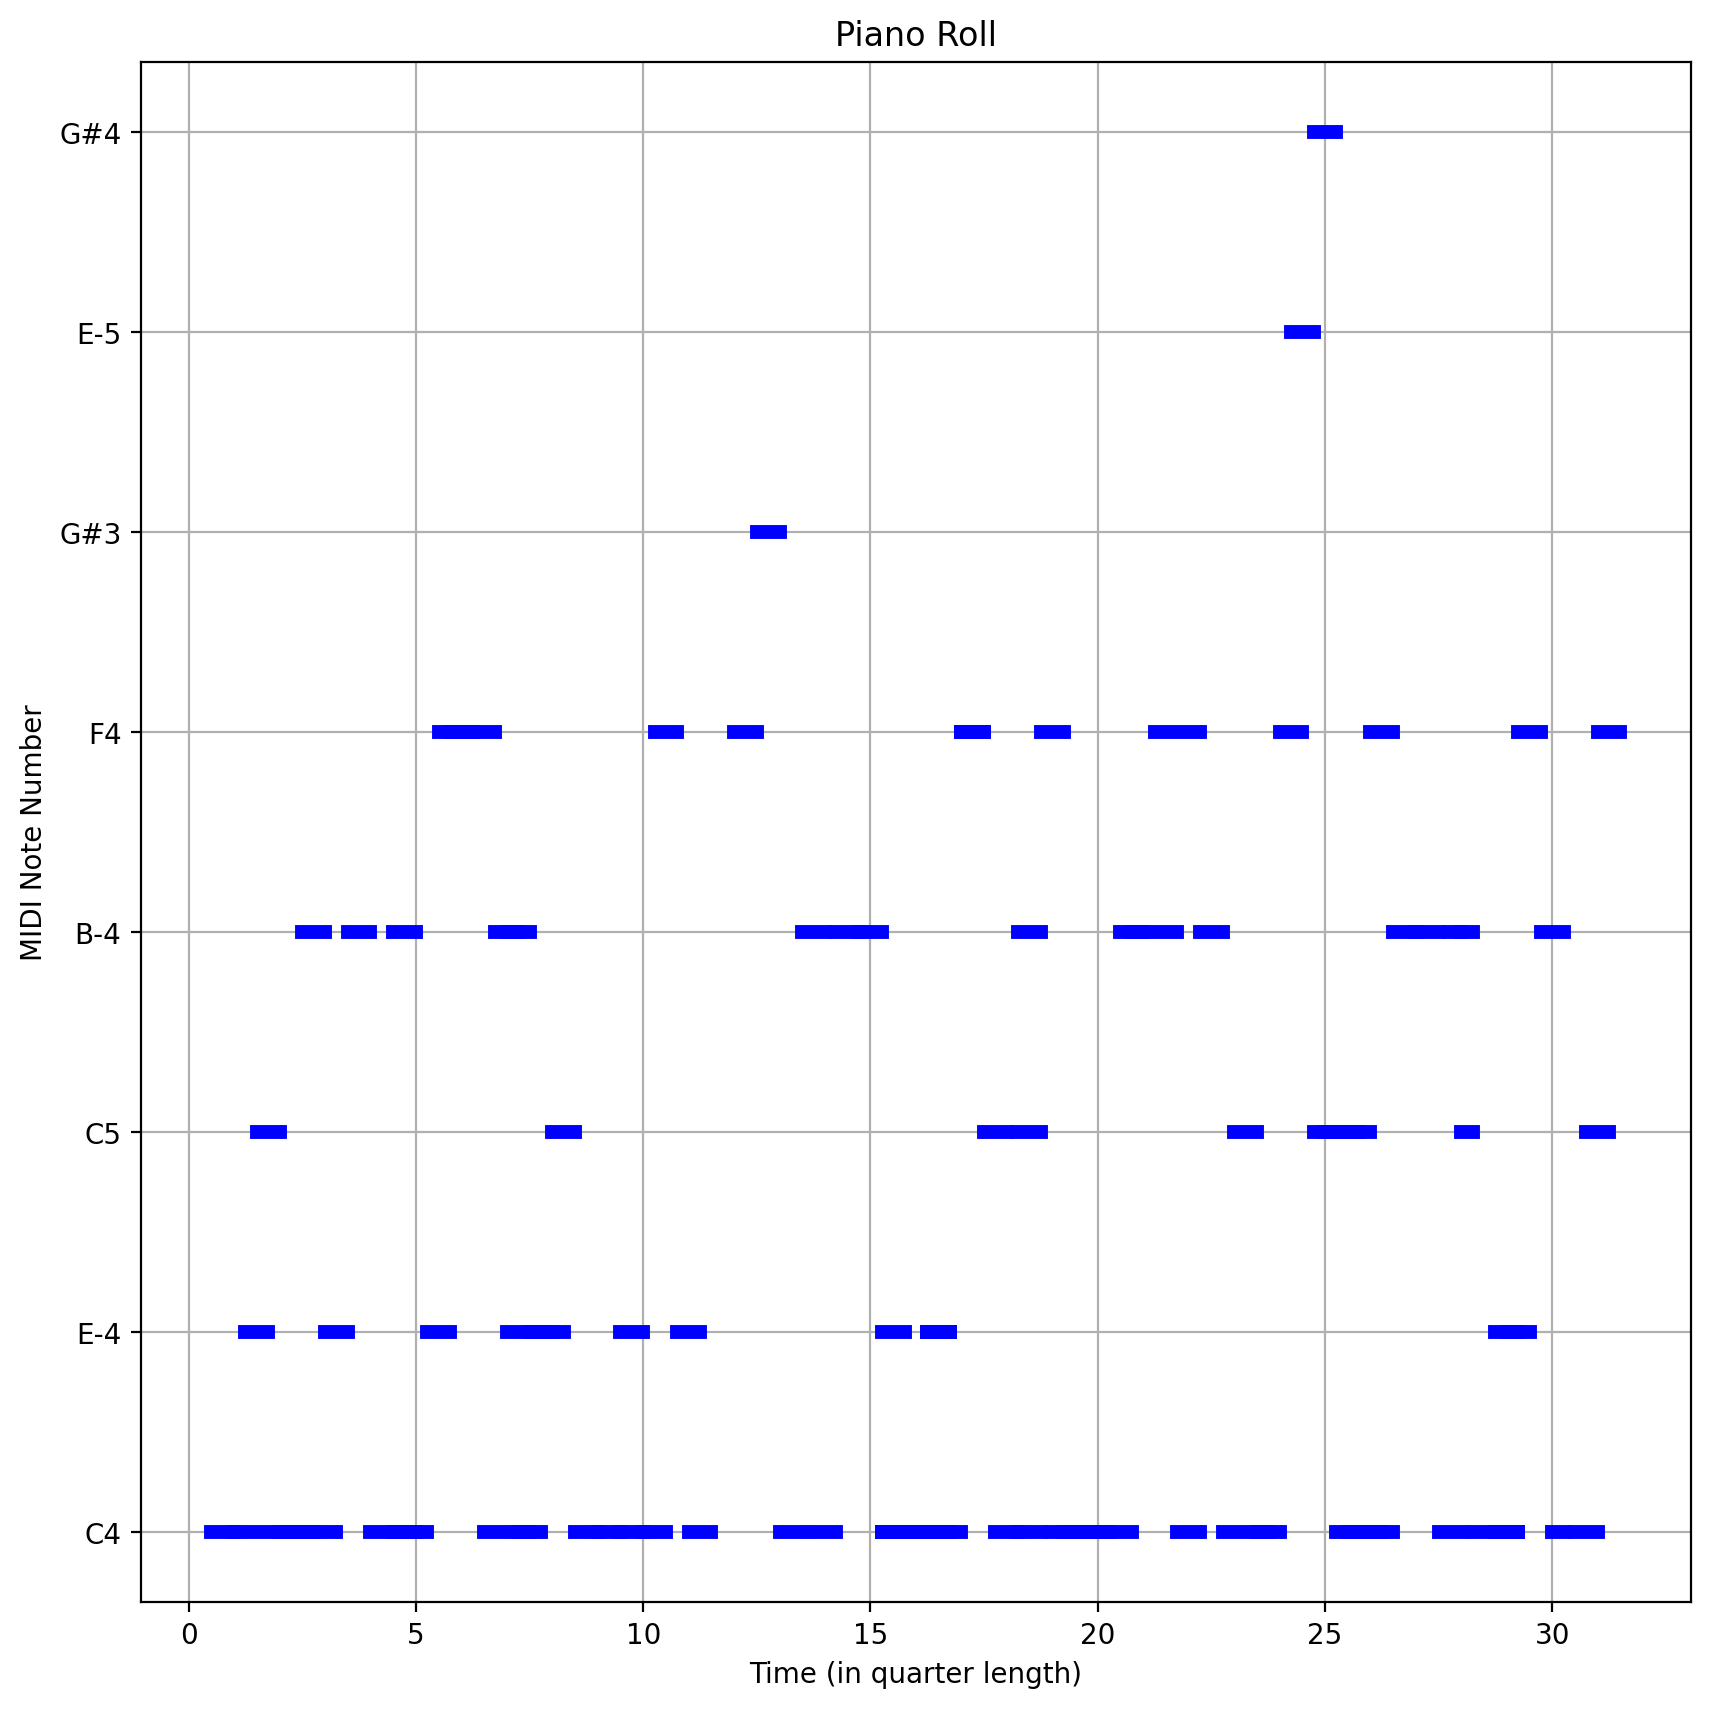

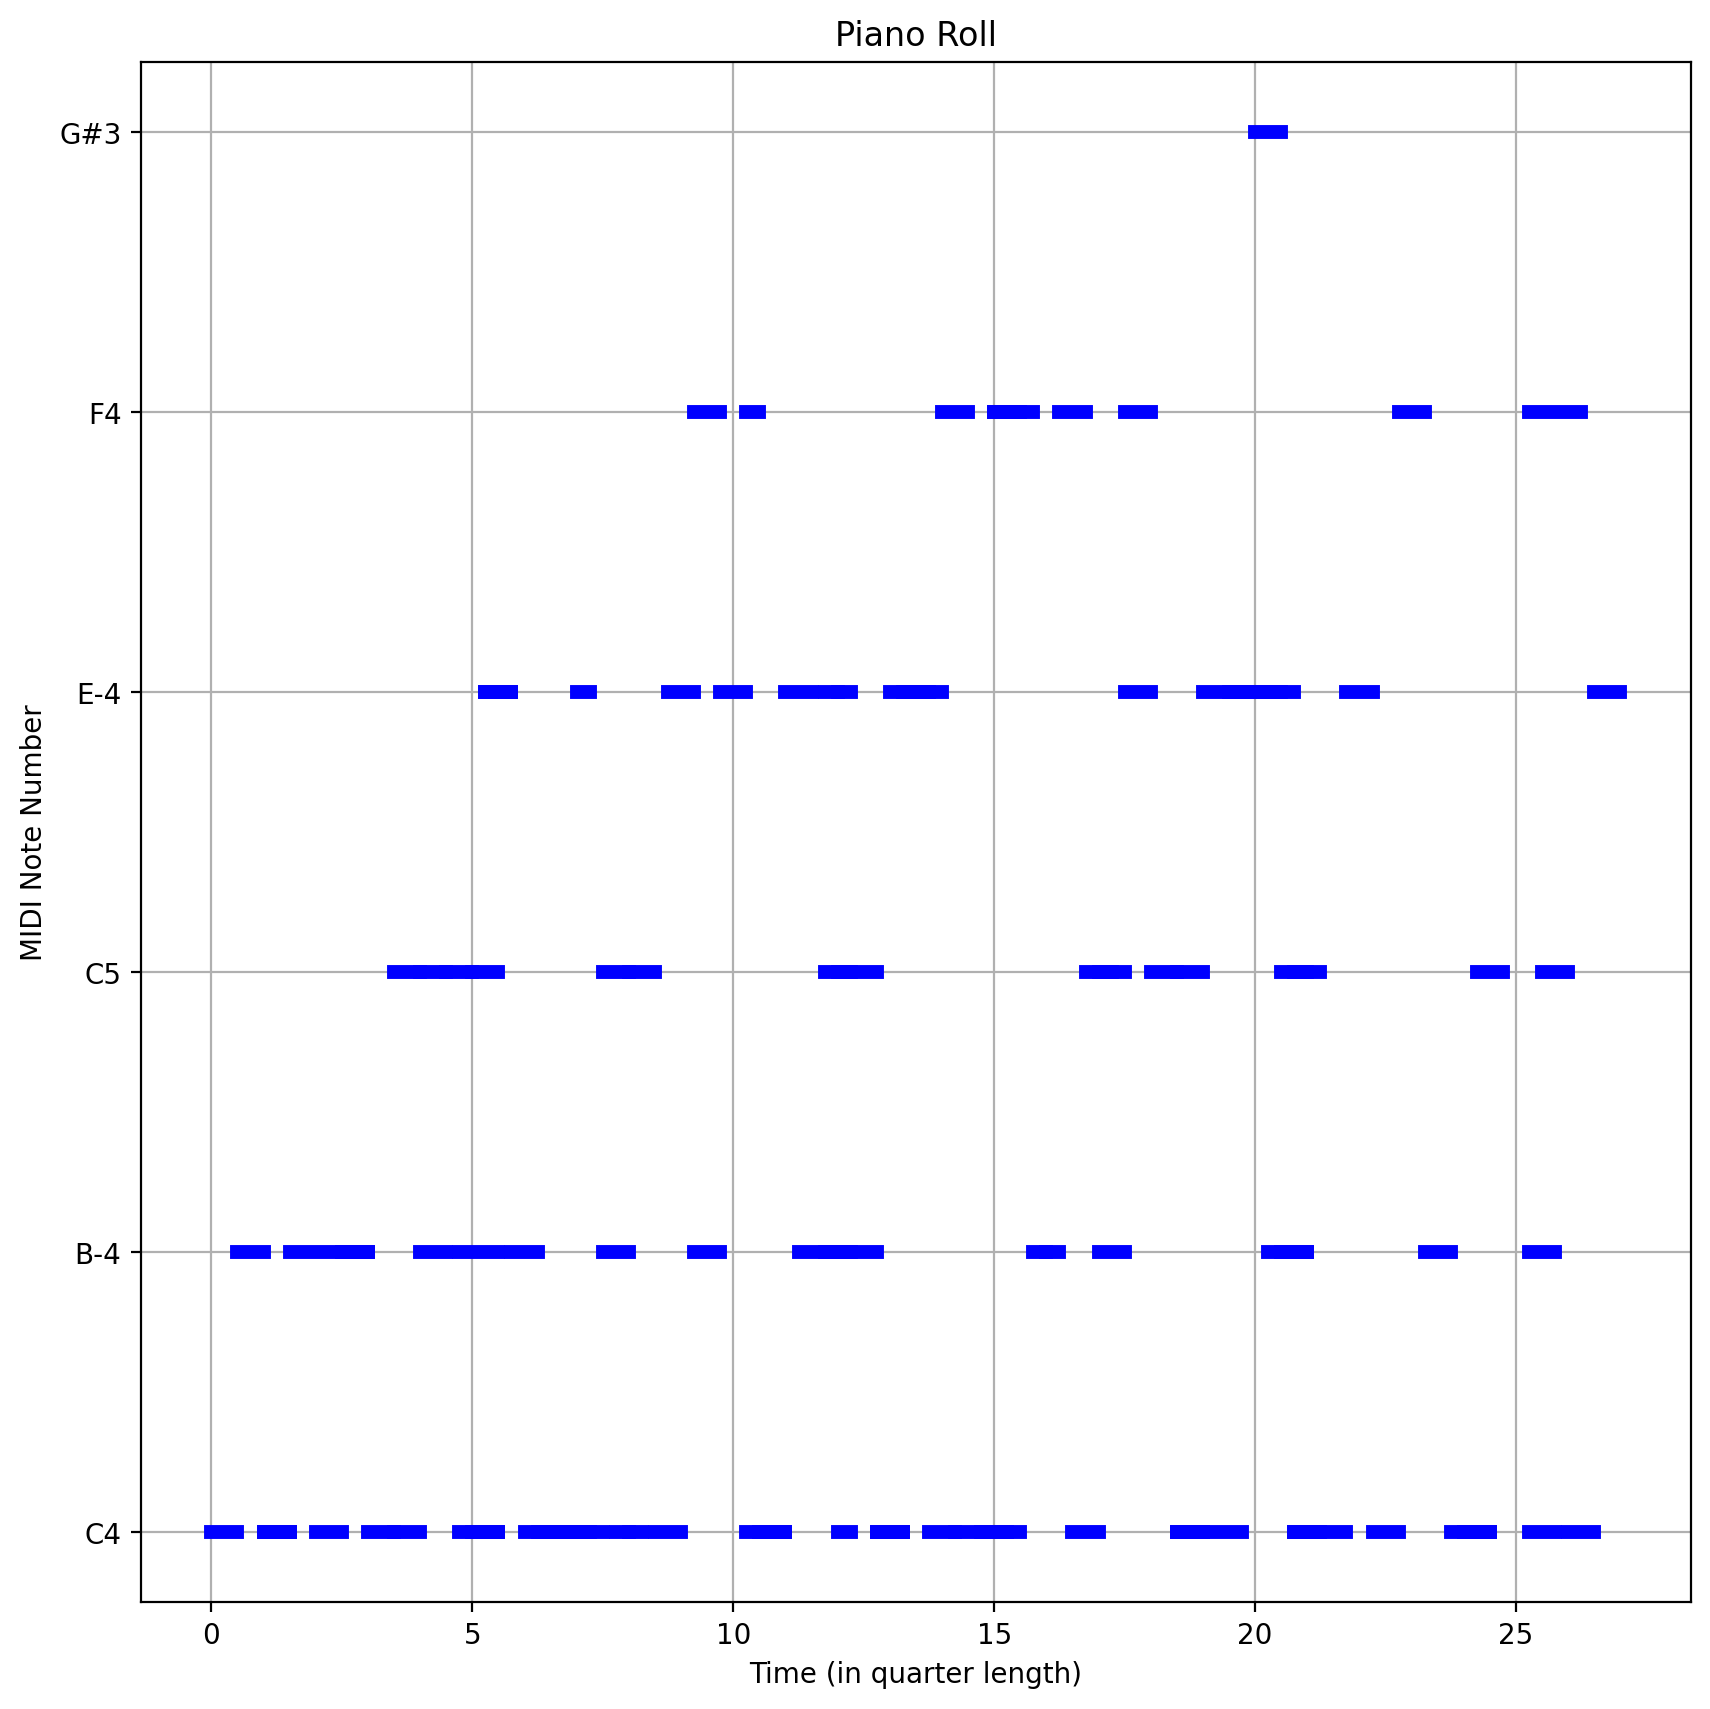

In [30]:
if folder_path.endswith(('.mid', '.midi')):
    folder_path = folder_path.split('.')[0]

for i in range(3):
    prediction_output = generate_notes_and_durations(
    model, 
    (network_input_notes, network_input_durations, network_input_offsets),
    pitchnames,
    durationnames,
    offsetnames,
    (n_vocab, d_vocab, o_vocab),
    notes = 100,
    temperature = 0.25)
    
    notes, durations, offsets = prediction_output
    
    file = f'./generated files/model {model_num}/{folder_path}/artifact {i}.mid'

    create_midi_from_notes(notes, durations, offsets,file)
    plot_piano_roll(file)

[0] adl-piano-midi\Rock\Soft Rock\Lionel Richie\Say You Say Me.mid
[0] ./generated files/model 4/\Rock\Soft Rock\Lionel Richie\Say You Say Me/artifact 1.mid


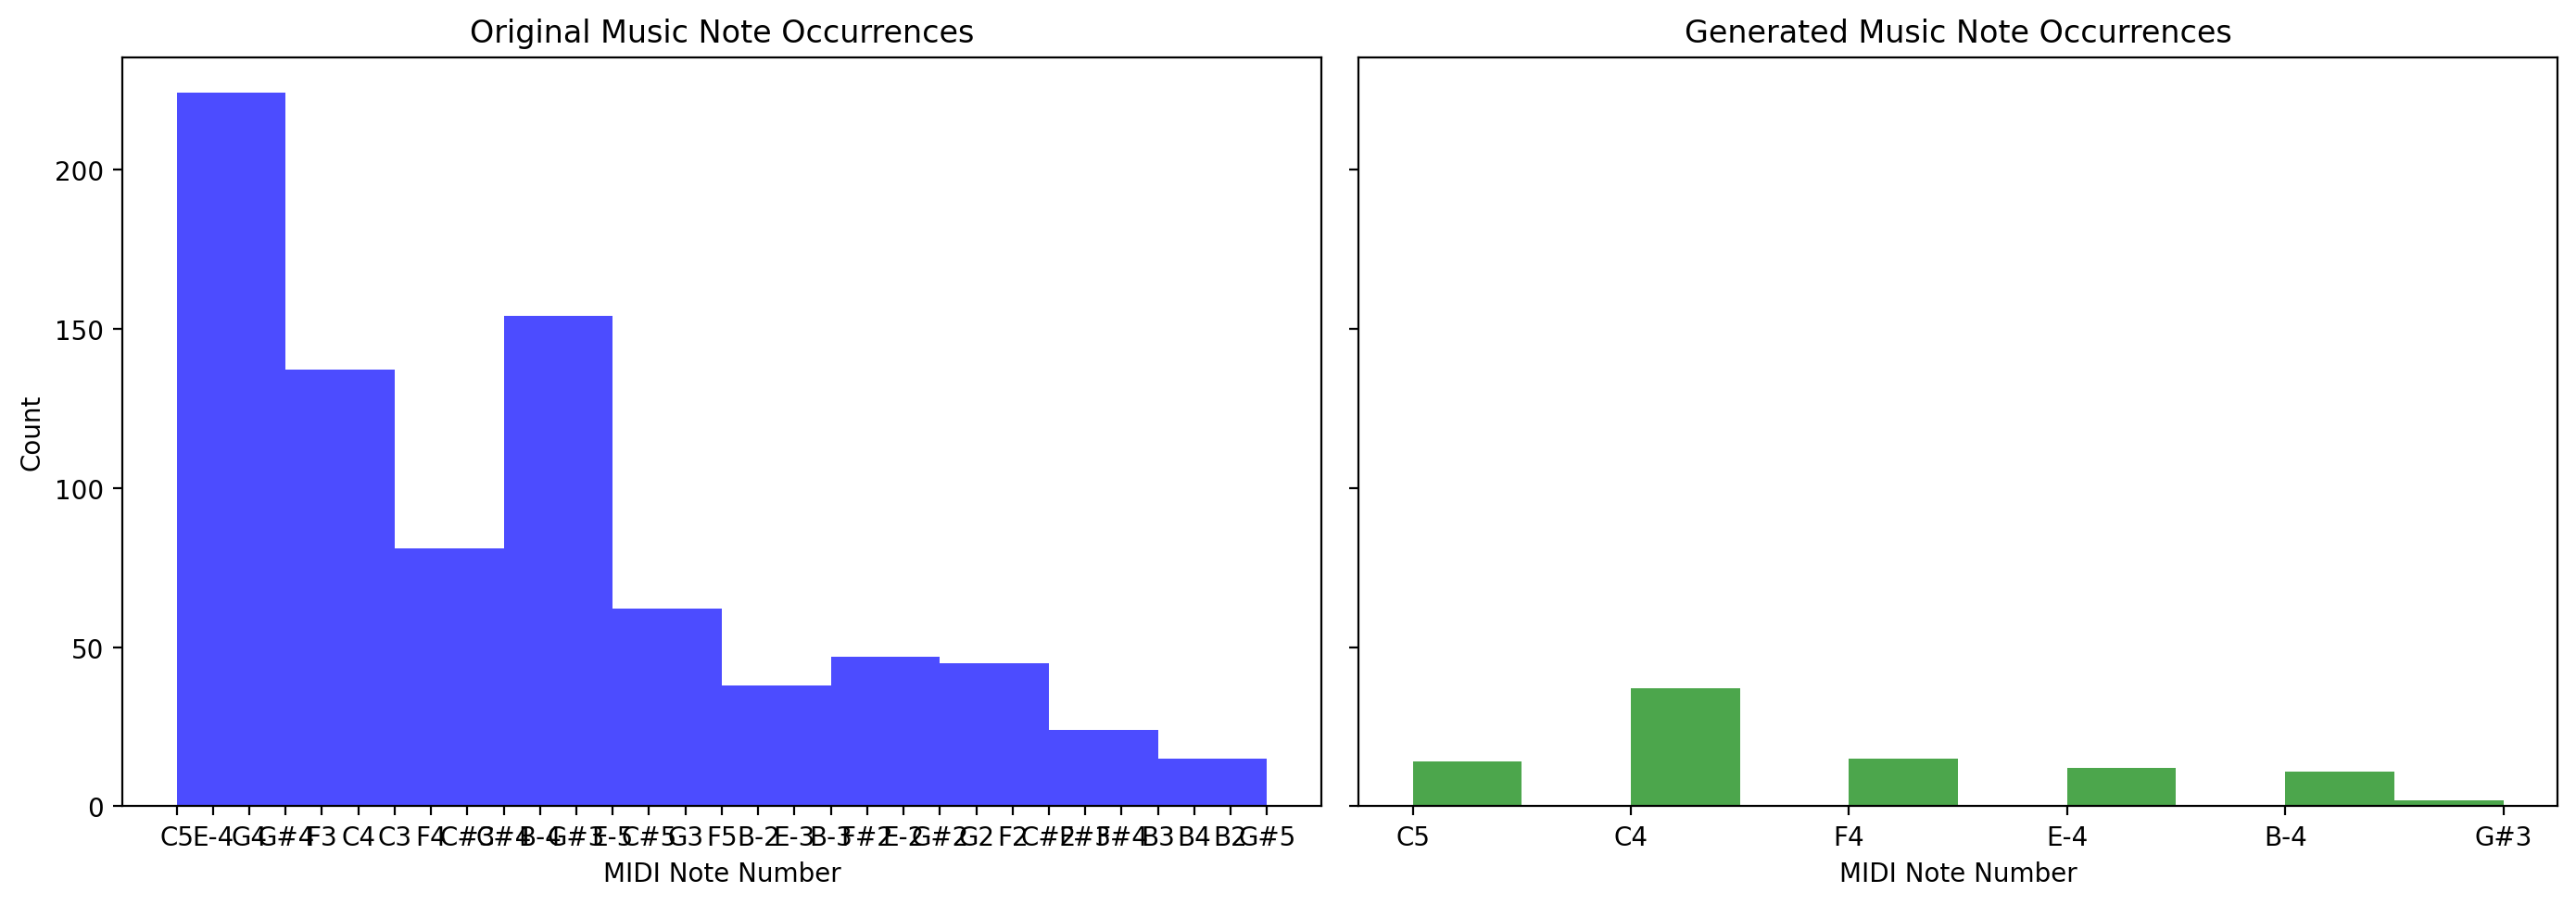

In [23]:
def plot_note_histograms(original_midi_path, generated_midi_path):
    original_notes = get_notes_and_durations(original_midi_path)[0][0]
    generated_notes = get_notes_and_durations(generated_midi_path)[0][0]

    fig, axs = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
    
    axs[0].hist(original_notes, color='blue', alpha=0.7)
    axs[0].set_title('Original Music Note Occurrences')
    axs[0].set_xlabel('MIDI Note Number')
    axs[0].set_ylabel('Count')
    
    axs[1].hist(generated_notes, color='green', alpha=0.7)
    axs[1].set_title('Generated Music Note Occurrences')
    axs[1].set_xlabel('MIDI Note Number')
    
    plt.tight_layout()
    plt.show()

# Example usage
plot_note_histograms('adl-piano-midi\\Rock\\Soft Rock\\Lionel Richie\\Say You Say Me.mid', f'./generated files/model {model_num}/{folder_path}/artifact 1.mid')


The music generation phase is the practical realization of the project's overarching goal: to explore the capabilities of neural networks in understanding and creating music. It serves as the test of the models' ability to not just mimic but creatively apply the patterns and structures learned from their training data.

This effectively demonstrates the intersection of artificial intelligence and creativity, showcasing how machine learning models can be applied to artistic endeavors like music composition. The generated music serves as a tangible output that can be evaluated for its musicality, coherence, and innovation, providing insights into the potential and limitations of current AI approaches to music generation.

Considering the generated artifacts, it seems that higher quality results is produced from more specified datasets, with less variety.
For example, an input dataset containing only a single artist results in a more pleasing generation than that of a bigger collection of a sub genre for example.

A validation loss in a equally weighted model of less than 9.0 usually results in some pleasing generations

## Conclusion

The development of the coursework demonstrates an improvement in understanding and applying musical data processing and generative network training. The change from mido to music21 improved the handling of musical data, allowing for a better extraction of musical features. This change was important for the next parts of this project.

Through regular improvements, the project began to focus on pitch, note duration, and offsets, leading to a better way of handling chords and making the dataset simpler for network training. This careful preparation of musical data helped in creating neural network models that can learn and predict musical patterns, which allowed them to generate new music compositions. The models became more advanced over time, using technologies like LSTM, bidirectional LSTMs, and attention mechanisms to improve their performance.

The training process used techniques like ModelCheckpoint and EarlyStopping to improve learning and ensure the models could create coherent and enjoyable music. The creation of music, the main goal of this work, shows how these models can be used in practice, demonstrating their ability to create innovative music that reflects the complexity of human compositions.

In summary, this document provides a detailed look into using neural networks for music generation. It shows the potential of machine learning to go beyond traditional limits and contribute creatively to music. The journey from basic MIDI file processing to creating new music pieces marks a notable progress in using artificial intelligence for creative purposes, opening up new possibilities for music composition and innovation.

## References

<div class="csl-bib-body" style="line-height: 1.35; ">
  <div class="csl-entry" style="margin-bottom: 1em;"><i>14.2. Fine-Tuning — Dive into Deep Learning 1.0.3 documentation</i> (no date). Available at: <a href="http://d2l.ai/chapter_computer-vision/fine-tuning.html">http://d2l.ai/chapter_computer-vision/fine-tuning.html</a> </div>
  <span class="Z3988" title="url_ver=Z39.88-2004&amp;ctx_ver=Z39.88-2004&amp;rfr_id=info%3Asid%2Fzotero.org%3A2&amp;rft_val_fmt=info%3Aofi%2Ffmt%3Akev%3Amtx%3Adc&amp;rft.type=webpage&amp;rft.title=14.2.%20Fine-Tuning%20%E2%80%94%20Dive%20into%20Deep%20Learning%201.0.3%20documentation&amp;rft.identifier=http%3A%2F%2Fd2l.ai%2Fchapter_computer-vision%2Ffine-tuning.html"></span>
  <div class="csl-entry" style="margin-bottom: 1em;">Chollet, F. (2018) <i>Deep learning with Python</i>. Shelter Island, New York: Manning Publications Co.</div>
  <span class="Z3988" title="url_ver=Z39.88-2004&amp;ctx_ver=Z39.88-2004&amp;rfr_id=info%3Asid%2Fzotero.org%3A2&amp;rft_id=urn%3Aisbn%3A978-1-61729-443-3&amp;rft_val_fmt=info%3Aofi%2Ffmt%3Akev%3Amtx%3Abook&amp;rft.genre=book&amp;rft.btitle=Deep%20learning%20with%20Python&amp;rft.place=Shelter%20Island%2C%20New%20York&amp;rft.publisher=Manning%20Publications%20Co&amp;rft.aufirst=Fran%C3%A7ois&amp;rft.aulast=Chollet&amp;rft.au=Fran%C3%A7ois%20Chollet&amp;rft.date=2018&amp;rft.tpages=361&amp;rft.isbn=978-1-61729-443-3&amp;rft.language=en"></span>
  <div class="csl-entry" style="margin-bottom: 1em;"><i>Mido - MIDI Objects for Python — Mido 1.3.2 documentation</i> (no date). Available at: <a href="https://mido.readthedocs.io/en/stable/">https://mido.readthedocs.io/en/stable/</a> </div>
  <span class="Z3988" title="url_ver=Z39.88-2004&amp;ctx_ver=Z39.88-2004&amp;rfr_id=info%3Asid%2Fzotero.org%3A2&amp;rft_val_fmt=info%3Aofi%2Ffmt%3Akev%3Amtx%3Adc&amp;rft.type=webpage&amp;rft.title=Mido%20-%20MIDI%20Objects%20for%20Python%20%E2%80%94%20Mido%201.3.2%20documentation&amp;rft.identifier=https%3A%2F%2Fmido.readthedocs.io%2Fen%2Fstable%2F"></span>
  <div class="csl-entry" style="margin-bottom: 1em;"><i>music21 Documentation — music21 Documentation</i> (no date). Available at: <a href="http://web.mit.edu/music21/doc/index.html">http://web.mit.edu/music21/doc/index.html</a> </div>
  <span class="Z3988" title="url_ver=Z39.88-2004&amp;ctx_ver=Z39.88-2004&amp;rfr_id=info%3Asid%2Fzotero.org%3A2&amp;rft_val_fmt=info%3Aofi%2Ffmt%3Akev%3Amtx%3Adc&amp;rft.type=webpage&amp;rft.title=music21%20Documentation%20%E2%80%94%20music21%20Documentation&amp;rft.identifier=http%3A%2F%2Fweb.mit.edu%2Fmusic21%2Fdoc%2Findex.html"></span>
  <div class="csl-entry" style="margin-bottom: 1em;"><i>Papers with Code - Computer-Generated Music for Tabletop Role-Playing Games</i> (no date). Available at: <a href="https://paperswithcode.com/paper/computer-generated-music-for-tabletop-role">https://paperswithcode.com/paper/computer-generated-music-for-tabletop-role</a> </div>
  <span class="Z3988" title="url_ver=Z39.88-2004&amp;ctx_ver=Z39.88-2004&amp;rfr_id=info%3Asid%2Fzotero.org%3A2&amp;rft_val_fmt=info%3Aofi%2Ffmt%3Akev%3Amtx%3Adc&amp;rft.type=webpage&amp;rft.title=Papers%20with%20Code%20-%20Computer-Generated%20Music%20for%20Tabletop%20Role-Playing%20Games&amp;rft.description=Implemented%20in%202%20code%20libraries.&amp;rft.identifier=https%3A%2F%2Fpaperswithcode.com%2Fpaper%2Fcomputer-generated-music-for-tabletop-role&amp;rft.language=en"></span>
  <div class="csl-entry" style="margin-bottom: 1em;">PhD, M.S. (2023) <i>Simple Guide to Hyperparameter Tuning in Neural Networks</i>, <i>Medium</i>. Available at: <a href="https://towardsdatascience.com/simple-guide-to-hyperparameter-tuning-in-neural-networks-3fe03dad8594">https://towardsdatascience.com/simple-guide-to-hyperparameter-tuning-in-neural-networks-3fe03dad8594</a> </div>
  <span class="Z3988" title="url_ver=Z39.88-2004&amp;ctx_ver=Z39.88-2004&amp;rfr_id=info%3Asid%2Fzotero.org%3A2&amp;rft_val_fmt=info%3Aofi%2Ffmt%3Akev%3Amtx%3Adc&amp;rft.type=webpage&amp;rft.title=Simple%20Guide%20to%20Hyperparameter%20Tuning%20in%20Neural%20Networks&amp;rft.description=A%20step-by-step%20Jupyter%20notebook%20walkthrough%20on%20hyperparameter%20optimization.&amp;rft.identifier=https%3A%2F%2Ftowardsdatascience.com%2Fsimple-guide-to-hyperparameter-tuning-in-neural-networks-3fe03dad8594&amp;rft.aufirst=Matthew%20Stewart&amp;rft.aulast=PhD&amp;rft.au=Matthew%20Stewart%20PhD&amp;rft.date=2023-02-10&amp;rft.language=en"></span>
  <div class="csl-entry" style="margin-bottom: 1em;">Team, K. (no date a) <i>Keras documentation: Concatenate layer</i>. Available at: <a href="https://keras.io/api/layers/merging_layers/concatenate/">https://keras.io/api/layers/merging_layers/concatenate/</a> </div>
  <span class="Z3988" title="url_ver=Z39.88-2004&amp;ctx_ver=Z39.88-2004&amp;rfr_id=info%3Asid%2Fzotero.org%3A2&amp;rft_val_fmt=info%3Aofi%2Ffmt%3Akev%3Amtx%3Adc&amp;rft.type=webpage&amp;rft.title=Keras%20documentation%3A%20Concatenate%20layer&amp;rft.description=Keras%20documentation&amp;rft.identifier=https%3A%2F%2Fkeras.io%2Fapi%2Flayers%2Fmerging_layers%2Fconcatenate%2F&amp;rft.aufirst=Keras&amp;rft.aulast=Team&amp;rft.au=Keras%20Team&amp;rft.language=en"></span>
  <div class="csl-entry">Team, K. (no date b) <i>Keras documentation: LSTM layer</i>. Available at: <a href="https://keras.io/api/layers/recurrent_layers/lstm/">https://keras.io/api/layers/recurrent_layers/lstm/</a> </div>
  <span class="Z3988" title="url_ver=Z39.88-2004&amp;ctx_ver=Z39.88-2004&amp;rfr_id=info%3Asid%2Fzotero.org%3A2&amp;rft_val_fmt=info%3Aofi%2Ffmt%3Akev%3Amtx%3Adc&amp;rft.type=webpage&amp;rft.title=Keras%20documentation%3A%20LSTM%20layer&amp;rft.description=Keras%20documentation&amp;rft.identifier=https%3A%2F%2Fkeras.io%2Fapi%2Flayers%2Frecurrent_layers%2Flstm%2F&amp;rft.aufirst=Keras&amp;rft.aulast=Team&amp;rft.au=Keras%20Team&amp;rft.language=en"></span>
</div>